## load data, separate features for PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [2]:
%run ../Jane/extract_data.py

Your data is ready! Merged table name is zillow_full.


In [3]:
zillow_full = zillow_full.drop(['PersonalIncome','AQIMean','Vol_moderate_income','Vol_low_income'],axis=1)
# separate the cols that won't go into the pca
zillow = zillow_full[['Zipcode','City','State','Metro','County','SizeRank','Date','Rent','Year','State-County']].copy()
features = zillow_full.drop(['Zipcode','City','State','Metro','County','SizeRank','Date','Rent',
                             'Year','State-County'], axis = 1).copy()

In [4]:
scaler = StandardScaler()

features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns)

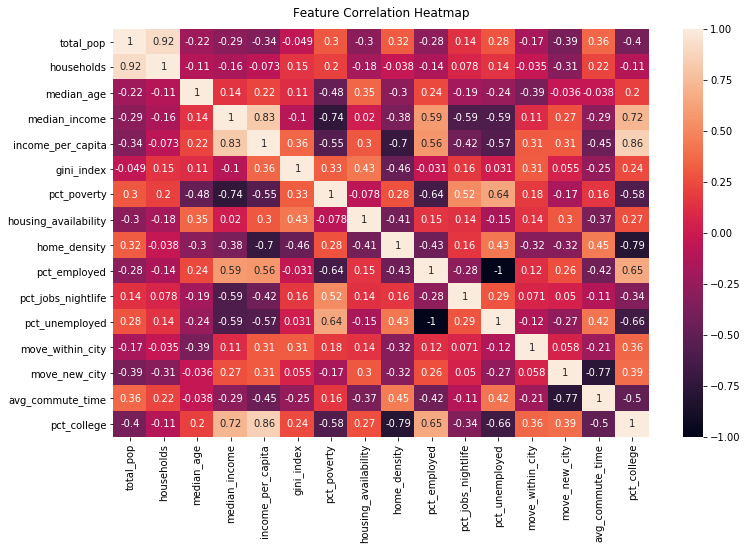

In [5]:
# Assess correlations between features for multicollinearity
plt.figure(figsize=(12, 7.5)) # larger for ease of viewing

heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## PCA 1: socioeconomic features

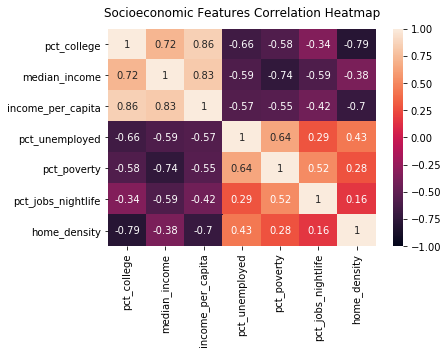

In [6]:
# check correlations
socioeconomic = features[['pct_college','median_income','income_per_capita','pct_unemployed','pct_poverty',
                          'pct_jobs_nightlife','home_density']]
heatmap = sns.heatmap(socioeconomic.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Socioeconomic Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [7]:
from PCARandomForest import screePlot, featurePlotPCA # local .py file

[0.6307501  0.15998221 0.0933639  0.05347054 0.03849601 0.01508871
 0.00884853]


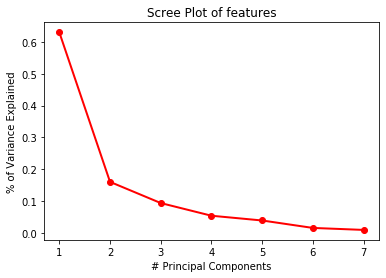

In [8]:
screePlot(socioeconomic) # 3 principal components is sufficient

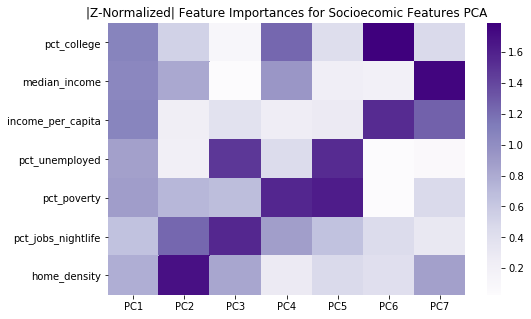

In [9]:
featurePlotPCA(socioeconomic, df_name='Socioecomic Features')

In [10]:
pca = PCA(n_components=3) 
econPC = pd.DataFrame(pca.fit_transform(socioeconomic),columns=['econPC1','econPC2','econPC3'])

In [11]:
# remove features from feature df if they were included in the above PCA
features = features.drop(['pct_college','median_income','income_per_capita','pct_unemployed','pct_poverty',
                          'pct_jobs_nightlife','home_density'],axis=1)

In [12]:
# PCA above used the feature pct_unemployed. 1 - pct_employed = pct_employed ; this is a redundant feature -
# drop it from the feature df
features = features.drop(['pct_employed'],axis=1)

## PCA 2: zip code-level features ("neighborhood/city features")

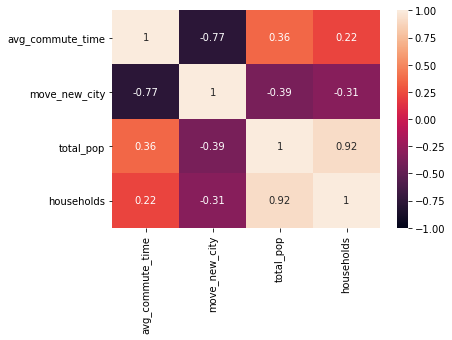

In [13]:
# select a second subset of features; check corrs
cityfeats = features[['avg_commute_time','move_new_city','total_pop','households']]
heatmap = sns.heatmap(cityfeats.corr(), vmin=-1, vmax=1, annot=True)

[0.62361709 0.30134057 0.05814203 0.01690031]


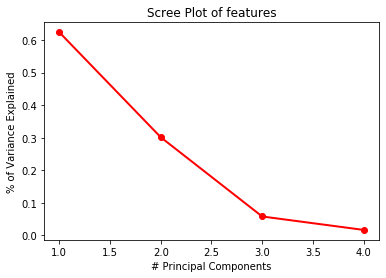

In [14]:
screePlot(cityfeats) # 2 prinicipal components seem sufficient

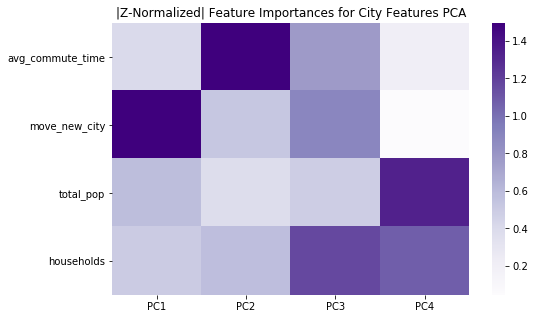

In [15]:
featurePlotPCA(cityfeats, df_name='City Features')

In [16]:
pca = PCA(n_components=2) 
cityPC = pd.DataFrame(pca.fit_transform(cityfeats),columns=['cityPC1','cityPC2'])

In [17]:
# remove features from feature df if they were included in the above PCA
features = features.drop(['avg_commute_time','move_new_city','total_pop','households'],axis=1)

## recombine to one dataframe

In [18]:
zillow_withPCA = pd.concat((zillow[['Zipcode','Date','Rent']],features,cityPC,econPC),axis=1)
zillow_withPCA.set_index('Date',inplace=True)

In [19]:
zillow_withPCA.head()
#zillow_withPCA.to_csv('../../data/zillow_withPCA.csv')

,Zipcode,Rent,median_age,gini_index,housing_availability,move_within_city,cityPC1,cityPC2,econPC1,econPC2,econPC3
Date,,,,,,,,,,,
2015-01-01,10025,3566.0,0.677914,2.090545,0.165373,0.557787,2.639140,-2.550477,1.262548,0.468466,0.925527
2015-01-01,10023,3413.0,1.069040,1.450117,0.768800,0.220614,1.345266,-1.517568,3.702114,0.669070,0.887342
2015-01-01,10002,3508.0,1.127709,1.861821,-0.524889,-0.408679,2.039872,-1.296285,-1.479641,2.158627,-0.070177
2015-01-01,11226,1876.0,-0.612804,-0.261799,-0.271246,-0.598288,3.553812,-1.140753,-1.048525,-0.156592,0.185801
2015-01-01,10467,1442.0,-0.808367,0.053137,-0.650615,0.799210,3.724402,-1.103695,-2.999483,0.495772,1.410110


## random forest

In [20]:
from PCARandomForest import train_test, randForest

In [21]:
y = np.log(zillow_withPCA['Rent'])
X = zillow_withPCA.drop(['Rent'],axis=1)

In [22]:
Xtrain,Xtest,ytrain,ytest = train_test(X,y)

In [23]:
# try with only the PC cols
Xtrain = Xtrain.drop(['Zipcode','median_age','gini_index','housing_availability','move_within_city'],axis=1)
Xtest = Xtest.drop(['Zipcode','median_age','gini_index','housing_availability','move_within_city'],axis=1)

In [24]:
rfc = RandomForestRegressor(n_estimators=600)
randForest(rfc,Xtrain,Xtest,ytrain,ytest)

training R2: 0.9759590873907432
test R2: 0.9474868252406794
RMSE: 135.10329465088498


,Columns,Feature_importances
2,econPC1,0.450790
0,cityPC1,0.214362
4,econPC3,0.146673
3,econPC2,0.107438
1,cityPC2,0.080736


## grid search to parameter tune

In [229]:
param_grid = {'n_estimators':[250,300,400,500,700,1000],
              'max_features':['auto','sqrt','log2'],
              'min_samples_split':[2,5,10,15,20,50],
              'min_samples_leaf':[1,2,5,10,15]
             }

grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid,return_train_score=True)

In [230]:
# started running at 12:37:30
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [233]:
grid.best_params_

{'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 250}

In [247]:
grid_results = pd.DataFrame.from_dict(grid.cv_results_)
grid_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

In [253]:
grid_results[['param_max_features','param_min_samples_leaf','param_min_samples_split','param_n_estimators',
             'mean_test_score','mean_train_score','rank_test_score']].sort_values('rank_test_score').head(20)

,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score,rank_test_score
258,sqrt,5,5,250,0.965568,0.977268,1
468,log2,10,2,250,0.965565,0.977268,2
277,sqrt,5,20,300,0.965563,0.977268,3
415,log2,2,15,300,0.965558,0.977269,4
234,sqrt,2,15,250,0.965557,0.977268,5
270,sqrt,5,15,250,0.965557,0.977268,6
223,sqrt,2,5,300,0.965556,0.977268,7
432,log2,5,2,250,0.965556,0.977268,8
126,auto,10,15,250,0.965556,0.977268,9
116,auto,10,5,400,0.965554,0.977269,10


In [258]:
rfc = RandomForestRegressor(max_features='sqrt',n_estimators=500)
param_grid = {'min_samples_split':[10,20,30,50,100],
              'min_samples_leaf':[5,10,20,35,50]
             }

grid = GridSearchCV(RandomForestRegressor(),param_grid = param_grid,return_train_score=True)

In [259]:
# started at 6:10pm
grid.fit(Xtrain,ytrain)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [265]:
grid_results = pd.DataFrame.from_dict(grid.cv_results_)
grid_results.sort_values('rank_test_score')[['param_min_samples_leaf','param_min_samples_split','rank_test_score','mean_train_score','mean_test_score']]

,param_min_samples_leaf,param_min_samples_split,rank_test_score,mean_train_score,mean_test_score
7,10,30,1,0.977265,0.965530
6,10,20,2,0.977265,0.965529
0,5,10,3,0.977265,0.965525
5,10,10,4,0.977265,0.965524
2,5,30,5,0.977264,0.965512
1,5,20,6,0.977265,0.965491
12,20,30,7,0.977170,0.965460
10,20,10,8,0.977159,0.965419
11,20,20,9,0.977161,0.965387
13,20,50,10,0.976400,0.964665
